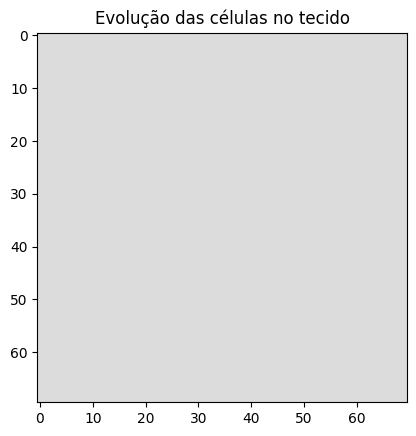

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import display

''' ---------- Parâmetros do sistema ----------- '''

N = 70                                     # Tamanho da grade Nxn              
qtde_tum = 100                             # Quantidade inicial de células tumorais
qtde_norm = 960                            # Quantidade incial de células normais

td_norm = 12                               # Tempo de duplicação das células normais
tm_norm = 50                               # Tempo para a morte da célula normal
td_tum = 6                                 # Tempo de duplicação das células tumorais
tm_tum = 25                                # Tempo para a morte da célula tumoral
pb_mut = 0.1                               # Probabilidade de mutação das células

steps = 100                                # Número de passos de simulação

''' --------------------------------------------- '''

# Códigos das células
EMPTY, NORMAL, TUMORAL = 0, 1, -1

# Inicialização da rede e da matriz de tempo para morte
tecido = np.zeros((N, N), dtype=int)
tempo_norm = np.zeros((N, N), dtype=int)
tempo_tum = np.zeros((N, N), dtype=int)

# Distribuição inicial aleatória
posicoes = np.random.permutation(N * N)
coords = np.array([(p // N, p % N) for p in posicoes])
for i in range(int(qtde_norm)):
    x, y = coords[i]
    tecido[x, y] = NORMAL
for i in range(int(qtde_norm), int(qtde_norm + qtde_tum)):
    x, y = coords[i]
    tecido[x, y] = TUMORAL

# Funções auxiliares
def vizinhos(x, y):
    return [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)] if 0 <= x+dx < N and 0 <= y+dy < N]

def celulas_vazias(matriz):
    return list(zip(*np.where(matriz == EMPTY)))

# Histórico das populações
hist_norm = []
hist_tum = []

# Setup para animação
fig, ax = plt.subplots()
img = ax.imshow(tecido, cmap='coolwarm_r', vmin=-1, vmax=1)
ax.set_title("Evolução das células no tecido")

def update(frame):
    global tecido, tempo_norm, tempo_tum
    novo_tecido = np.zeros_like(tecido)
    novo_t_norm = np.zeros_like(tempo_norm)
    novo_t_tum = np.zeros_like(tempo_tum)
    ocupada = np.zeros((N, N), dtype=bool)

    # --- Movimento (com buffer para evitar sobrescrita) ---
    movimentos = []
    for x in range(N):
        for y in range(N):
            if tecido[x, y] != EMPTY:
                np.random.shuffle(viz := vizinhos(x, y))
                for xn, yn in viz:
                    if tecido[xn, yn] == EMPTY and not ocupada[xn, yn]:
                        movimentos.append((x, y, xn, yn))
                        ocupada[xn, yn] = True
                        break
                else:
                    ocupada[x, y] = True

    # Aplicar movimentos
   # for x_old, y_old, x_new, y_new in movimentos:
    #    celula = tecido[x_old, y_old]
     #   novo_tecido[x_new, y_new] = celula
      #  if celula == NORMAL:
       #     tempo_norm[x_new, y_new] = tempo_norm[x_old, y_old] + 1
        #elif celula == TUMORAL:
         #   tempo_tum[x_new, y_new] = tempo_tum[x_old, y_old] + 1 
            
    # Para quem não se moveu
    for x in range(N):
        for y in range(N):
            if not novo_tecido[x, y] and ocupada[x, y]:
                novo_tecido[x, y] = tecido[x, y]
                if tecido[x, y] == NORMAL:
                    tempo_norm[x, y] = tempo_norm[x, y] + 1
                elif tecido[x, y] == TUMORAL:
                    tempo_tum[x, y] = tempo_tum[x, y] + 1

    # --- Duplicação ---
    for x in range(N):
        for y in range(N):
            if novo_tecido[x, y] == NORMAL:
                if tempo_norm[x, y] >= td_norm:
                    livres = celulas_vazias(novo_tecido)
                    if livres:
                        xnv, ynv = livres[np.random.randint(len(livres))]
                        novo_tecido[xnv, ynv] = NORMAL
            elif novo_tecido[x, y] == TUMORAL:
                if tempo_tum[x, y] >= td_tum:
                    livres = celulas_vazias(novo_tecido)
                    if livres:
                        xnv, ynv = livres[np.random.randint(len(livres))]
                        novo_tecido[xnv, ynv] = TUMORAL
                                
        # --- Tempo de vida ---
    for x in range(N):
        for y in range(N):
            if novo_tecido[x, y] == NORMAL:
                if tempo_norm[x, y] >= tm_norm:
                    novo_tecido[x, y] = EMPTY
                    novo_t_norm[x, y] = 0
            elif novo_tecido[x, y] == TUMORAL:
                if tempo_tum[x, y] >= tm_tum:
                    novo_tecido[x, y] = EMPTY
                    novo_t_tum[x, y] = 0

    # Atualizar estado global
    tecido[:] = novo_tecido
    tempo_norm[:] = novo_t_norm
    tempo_tum[:] = novo_t_tum
    hist_norm.append(np.sum(tecido == NORMAL))
    hist_tum.append(np.sum(tecido == TUMORAL))
    img.set_data(tecido)
    return [img]


# Criar animação
ani = animation.FuncAnimation(fig, update, frames=steps, blit=True)
display(HTML(ani.to_jshtml()))
